In [17]:
!pip install Keras-Preprocessing

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers import Embedding

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tijilchhabra/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# reading the GloVe embeddings and making a dictionary that maps a word to its vector.

embeddings_index = dict()
f = open('input/glove-global-vectors-for-word-representation/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [14]:
df_total = pd.read_csv('input/twitter-sentiment-analysis-hatred-speech/train.csv')
display(df_total.head())

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [16]:
# Since many tweets contain accents that add no value to the sentiment, we will remove these. We also remove stop words and user tags for the same reason.

def preprocess_text(tweet):
    tweet = tweet.lower() # Convert to lowercase
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet) # Remove words with non-ASCII characters
    words = tweet.split()
    words = filter(lambda x: x[0]!= '@' , tweet.split()) # Remove user tags
    words = [word for word in words if word not in set(stopwords.words('english'))] # Remove stop words
    tweet = " ".join(words)
    return tweet

In [26]:
df_total['preprocessedTweet'] = df_total.tweet.apply(preprocess_text)
display(df_total.head())

,id,label,tweet,preprocessedTweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't use cause offer whee...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur !!!
4,5,0,factsguide: society now #motivation,factsguide: society #motivation


In [28]:
df_total.isna().sum()

id                   0
label                0
tweet                0
preprocessedTweet    0
dtype: int64

**Tokenize**

To apply the GloVe embeddings, we have to first convert our text to sequences. We can use keras to define a vocabulary in which each word will have a unique index. We will pad shorter sentences to the max length (length of longest tweet after preprocessing).

In [35]:
max_length = df_total.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df_total.preprocessedTweet)
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(df_total.preprocessedTweet)
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

vocab_size = len(t.word_index) + 1

In [37]:
#mapping with GloVe
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
t.word_index

{'love': 1,
 'day': 2,
 'amp': 3,
 'happy': 4,
 'u': 5,
 'life': 6,
 'time': 7,
 'like': 8,
 'today': 9,
 'new': 10,
 'thankful': 11,
 'positive': 12,
 'get': 13,
 'good': 14,
 'people': 15,
 'bihday': 16,
 'one': 17,
 'see': 18,
 "can't": 19,
 'smile': 20,
 'go': 21,
 'want': 22,
 'me': 23,
 '2': 24,
 'take': 25,
 'work': 26,
 'fun': 27,
 'healthy': 28,
 'weekend': 29,
 'summer': 30,
 'make': 31,
 'family': 32,
 'us': 33,
 'got': 34,
 'friday': 35,
 'beautiful': 36,
 'i': 37,
 'best': 38,
 'friends': 39,
 'great': 40,
 'way': 41,
 'need': 42,
 'you': 43,
 'bull': 44,
 'days': 45,
 'going': 46,
 'first': 47,
 'really': 48,
 'music': 49,
 'wait': 50,
 'morning': 51,
 'back': 52,
 'ur': 53,
 'world': 54,
 'know': 55,
 'cute': 56,
 'tomorrow': 57,
 '3': 58,
 'sad': 59,
 'week': 60,
 'orlando': 61,
 "father's": 62,
 'never': 63,
 'it': 64,
 'fathersday': 65,
 'think': 66,
 'happiness': 67,
 'blog': 68,
 '1': 69,
 'feel': 70,
 'girl': 71,
 'right': 72,
 'home': 73,
 'sunday': 74,
 'trump': 

In [41]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13886   ,  1.1401    , -0.85211998, ..., -1.37109995,
        -0.28606001,  0.28979999],
       [ 0.11626   ,  0.53896999, -0.39513999, ..., -0.39061999,
        -0.10885   ,  0.084513  ],
       ...,
       [-0.56129003,  1.18040001,  0.69351   , ..., -0.80821002,
        -0.98431998, -0.44705001],
       [-1.04359996,  0.68566   , -0.60079002, ..., -1.58150005,
        -0.37354001,  0.86956   ],
       [-0.68303001, -0.074232  ,  0.093212  , ..., -0.17784999,
         0.082215  , -0.20570999]])

**TRAINING MODEL!!!!**

In [44]:
x_train, x_test, y_train, y_test = train_test_split(padded_tweets, df_total.label, test_size=0.2, stratify=df_total.label)

In [46]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True))
model_glove.add(Bidirectional(LSTM(20, return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(20, return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(20)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
model_glove.fit(x_train, y_train, epochs = 12)

Epoch 1/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9250 - loss: 0.2280
Epoch 2/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9510 - loss: 0.1276
Epoch 3/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9711 - loss: 0.0820
Epoch 4/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9831 - loss: 0.0499
Epoch 5/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9890 - loss: 0.0337
Epoch 6/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9936 - loss: 0.0220
Epoch 7/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9954 - loss: 0.0150
Epoch 8/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9975 - loss: 0.0096
Epoch 9/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9974 - loss: 0.0097
Epoch 10/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9976 - loss: 0.0081
Epoch 11/12
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9978 - loss: 0.0078
Epoch 12/12
800/800 ━━━━━━━━━━

**Evaluating or model <3**

In [51]:
y_pred = model_glove.predict(x_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


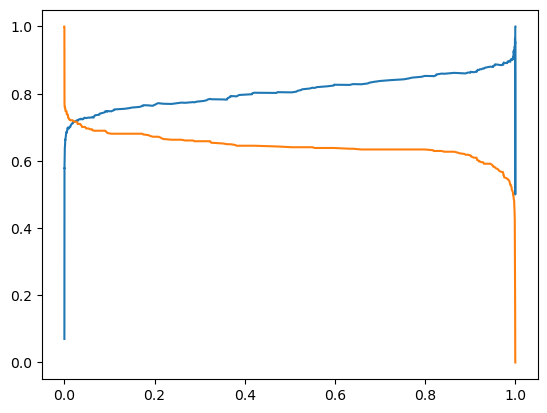

Crossover at 0.02 with recall 0.72
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.72      0.72      0.72       448

    accuracy                           0.96      6393
   macro avg       0.85      0.85      0.85      6393
weighted avg       0.96      0.96      0.96      6393



In [53]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))
print(classification_report(y_test, y_pred > crossover_cutoff))